# Домашнее задание №3 - Реализация базового варианта линейной регрессии

## Часть 1. Ваша реализация (60 баллов)

В этой части домашки вам предстоит **реализовать класс LinearRegressionSGD**, который обучает линейную регрессию методом стохастического градиентного спуска (SGD). Класс должен поддерживать **L1, L2 и Elastic Net регуляризацию**. Помимо этого, необходимо реализовать методы для **визуализации процесса обучения**: график функции потерь по эпохам и распределение ошибок на той или иной эпохе.

Ниже представлен шаблон кода с пропусками, которые необходимо заполнить.


* вычисление лосса (15 баллов)
* изменения в функции fit (25 баллов)
* predict (5 баллов)
* графики (15 баллов)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  # оказывается, это не подходит для регрессии
from sklearn.metrics import mean_absolute_error
import matplotlib.image as mpimg

In [2]:
class LinearRegressionSGD:
    def __init__(self, lr=0.01, epochs=1000, reg_type=None, reg_lambda=0.01, alpha=0.5):
        """
        Initialize the Linear Regression model with SGD.
        :param lr: Learning rate # Learning rate — это гиперпараметр в машинном обучении,
        который определяет, насколько модель корректирует свои параметры на
        каждом шаге оптимизационного алгоритма
        :param epochs: Number of training epochs
        :param reg_type: Regularization type ('l1', 'l2', 'elastic_net', or None)
        :param reg_lambda: Regularization strength
        :param alpha: Mixing parameter for elastic net (0: L2, 1: L1)
        """
        self.lr = lr
        self.epochs = epochs
        self.reg_type = reg_type
        self.reg_lambda = reg_lambda
        self.alpha = alpha
        self.theta = None  # веса модели
        self.loss_history = []
        self.error_history = []

    def _compute_loss(self, X, y):
        """Compute MSE loss with regularization."""
        m = len(y)
        predictions = X.dot(self.theta)
        loss = np.sum((predictions - y) ** 2) / (2 * m)  # Mean Squared Error

        if self.reg_type == "l2":
            loss += (
                self.reg_lambda * np.sum(self.theta**2) / 2
            )  # L2 Regularization lambda * (сумма от 1 до i wi^2)
            # Если бы мы не делили на 2, производная была бы в два раза больше
        elif self.reg_type == "l1":
            loss += self.reg_lambda * np.sum(
                np.abs(self.theta)
            )  # L1 Regularization lambda * (сумма от 1 до i |wi|)
        elif self.reg_type == "elastic_net":
            loss += self.reg_lambda * (
                self.alpha * np.sum(np.abs(self.theta))
                + (1 - self.alpha) * np.sum(self.theta**2) / 2
            )

        return loss

    def fit(self, X, y):
        """Train the model using stochastic gradient descent."""
        m, n = X.shape
        self.theta = np.zeros(n)

        for epoch in range(self.epochs):
            errors = []
            for i in range(m):
                idx = np.random.randint(
                    0, m
                )  # случайные точки для стохастического спуска
                xi, yi = X[idx], y[idx]
                prediction = np.dot(xi, self.theta)
                error = prediction - yi
                errors.append(error)

                # Compute gradient
                gradient = xi * error

                # Apply regularization
                if self.reg_type == "l2":
                    gradient += self.reg_lambda * self.theta
                elif self.reg_type == "l1":
                    gradient += self.reg_lambda * np.sign(self.theta)
                elif self.reg_type == "elastic_net":
                    gradient += self.reg_lambda * (
                        self.alpha * np.sign(self.theta) + (1 - self.alpha) * self.theta
                    )

                # Update weights
                self.theta -= self.lr * gradient

            # Compute loss at the end of each epoch
            loss = self._compute_loss(X, y)
            self.loss_history.append(loss)
            self.error_history.append(errors)

    def predict(self, X):
        """Make predictions using the trained model."""
        return np.dot(X, self.theta)

    def plot_loss(self, ax=None):  # Добавляем параметр ax
        """Plot the loss distribution over epochs."""
        if ax is None:
            fig, ax = plt.subplots()  # Создаем новую фигуру и оси, если ax не передан
        ax.plot(
            self.loss_history, label="Loss"
        )  # Отрисовываем график на переданных осях
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.set_title("Loss distribution over epochs")
        ax.legend()
        if ax is None:  # Показываем график только если ax не был передан
            plt.show()

    def plot_error_distribution(self, epoch, ax=None):  # Добавляем параметр ax
        """Plot the distribution of errors for all points at each epoch."""
        if ax is None:
            fig, ax = plt.subplots()  # Создаем новую фигуру и оси, если ax не передан
        errors = self.error_history[epoch]
        sns.histplot(
            errors, kde=True, ax=ax, label="Errors"
        )  # Отрисовываем гистограмму на переданных осях
        ax.set_xlabel("Error")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Error Distribution at Epoch {epoch}")
        ax.legend()
        if ax is None:  # Показываем график только если ax не был передан
            plt.show()

## Часть 2. Проверяем вашу реализацию (25 баллов)

Теперь для полученного класса вам нужно будет посмотреть, **как ведет себя регрессия для разных вариантов регуляризации**. Советуем рассмотреть несколько наборов значений для каждого вида регуляризации, а также посмотреть на несколько значений learning rate. 
 
Ваша цель - **понять какие значения лучше или хуже подходят** в случае ваших данных.

В качестве данных вам предлагается использовать сгенерированные выборки. Ниже представлен код для генерации.

In [3]:
sample_size = 500

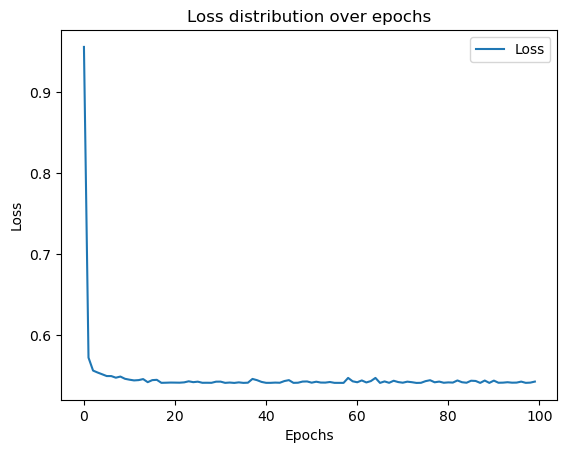

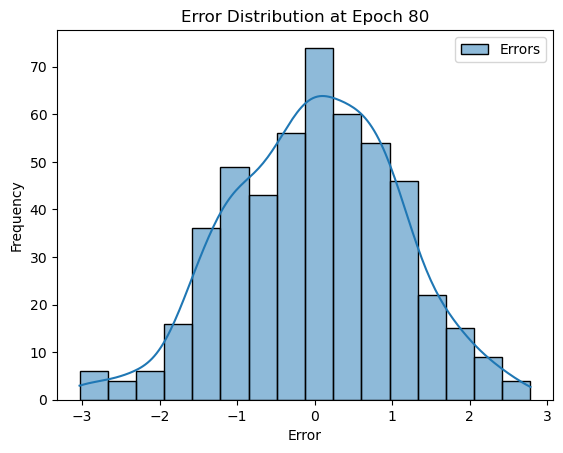

In [4]:
np.random.seed(1408)
X = 2 * np.random.rand(sample_size, 1)
y = 4 + 3 * X.squeeze() + np.random.randn(sample_size)

# Add bias term
X_b = np.c_[np.ones((sample_size, 1)), X]

model = LinearRegressionSGD(lr=0.002, epochs=100, reg_lambda=0.1, alpha=0.5)
model.fit(X_b, y)
model.plot_loss()
model.plot_error_distribution(80)

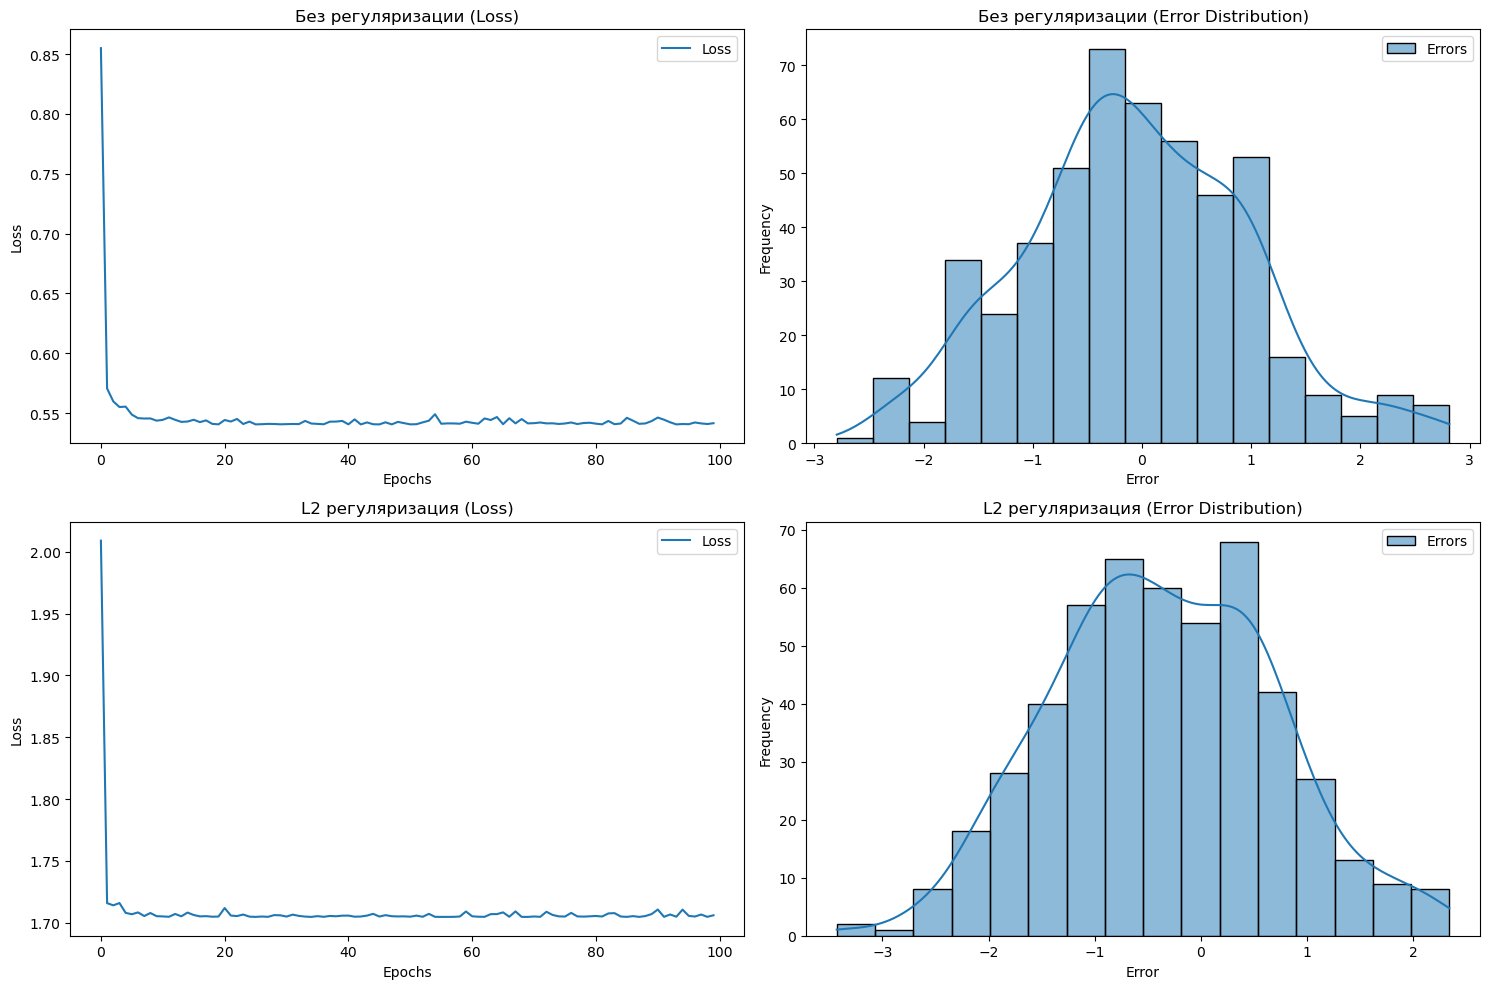

In [5]:
np.random.seed(1408)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_no_reg = LinearRegressionSGD(lr=0.002, epochs=100, reg_type=None)
model_no_reg.fit(X_b, y)
model_no_reg.plot_loss(ax=axes[0][0])
model_no_reg.plot_error_distribution(80, ax=axes[0][1])
axes[0][0].set_title("Без регуляризации (Loss)")
axes[0][1].set_title("Без регуляризации (Error Distribution)")

model_l2 = LinearRegressionSGD(lr=0.002, epochs=100, reg_type="l2", reg_lambda=0.1)
model_l2.fit(X_b, y)
model_l2.plot_loss(ax=axes[1][0])
model_l2.plot_error_distribution(80, ax=axes[1][1])
axes[1][0].set_title("L2 регуляризация (Loss)")
axes[1][1].set_title("L2 регуляризация (Error Distribution)")

plt.tight_layout()
plt.show()

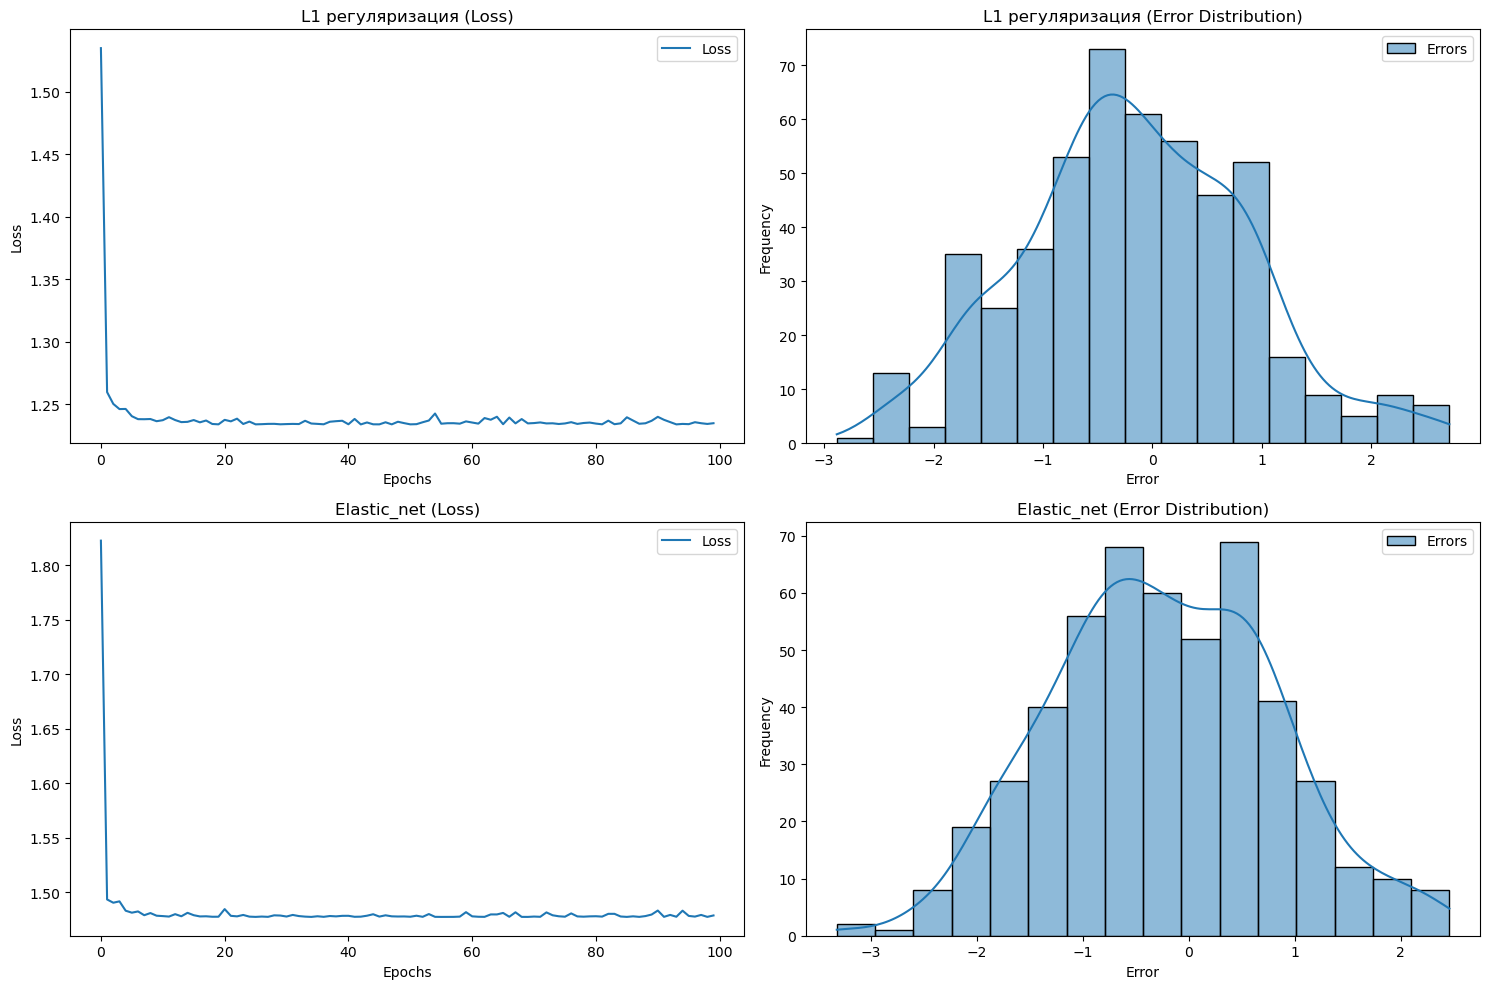

In [6]:
np.random.seed(1408)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_l1 = LinearRegressionSGD(lr=0.002, epochs=100, reg_type="l1", reg_lambda=0.1)
model_l1.fit(X_b, y)
model_l1.plot_loss(ax=axes[0][0])
model_l1.plot_error_distribution(80, ax=axes[0][1])
axes[0][0].set_title("L1 регуляризация (Loss)")
axes[0][1].set_title("L1 регуляризация (Error Distribution)")

model_elastic_net = LinearRegressionSGD(
    lr=0.002, epochs=100, reg_type="elastic_net", reg_lambda=0.1, alpha=0.5
)
model_elastic_net.fit(X_b, y)
model_elastic_net.plot_loss(ax=axes[1][0])
model_elastic_net.plot_error_distribution(80, ax=axes[1][1])
axes[1][0].set_title("Elastic_net (Loss)")
axes[1][1].set_title("Elastic_net (Error Distribution)")

plt.tight_layout()
plt.show()

Создается впечатление, что L1 регуляризация самая лучшая. Хотя если честно для меня все эти графики плюс-минус похожи. Просто на L1 самые маленькие пики, линия ровнее других, хотя смущает, что на эпохе 100 идет мини-подъем (может быть просто случайность?)

Upd1. C другой стороны, если смотреть на Error Distribution, то у модели без регулязации чаще встречаются значения в ошибке 0, а с регулязацией частоты ошибок повышаются в значении -1. На мой вкус этот график более информативен, так что считаю модель без регулязации самым лучшим

Upd2. Еще раз перезапустила графики. Что ж Error Distribution всегда разный, поэтому везде поставила np.random.seed(1408) (из-за того что перезапускую ячейки неравномерно)
Так как я поняла, что не стоит ориентироваться на кол-во значение в error 0, я возвращаюсь к своему мнению, что L1 топ


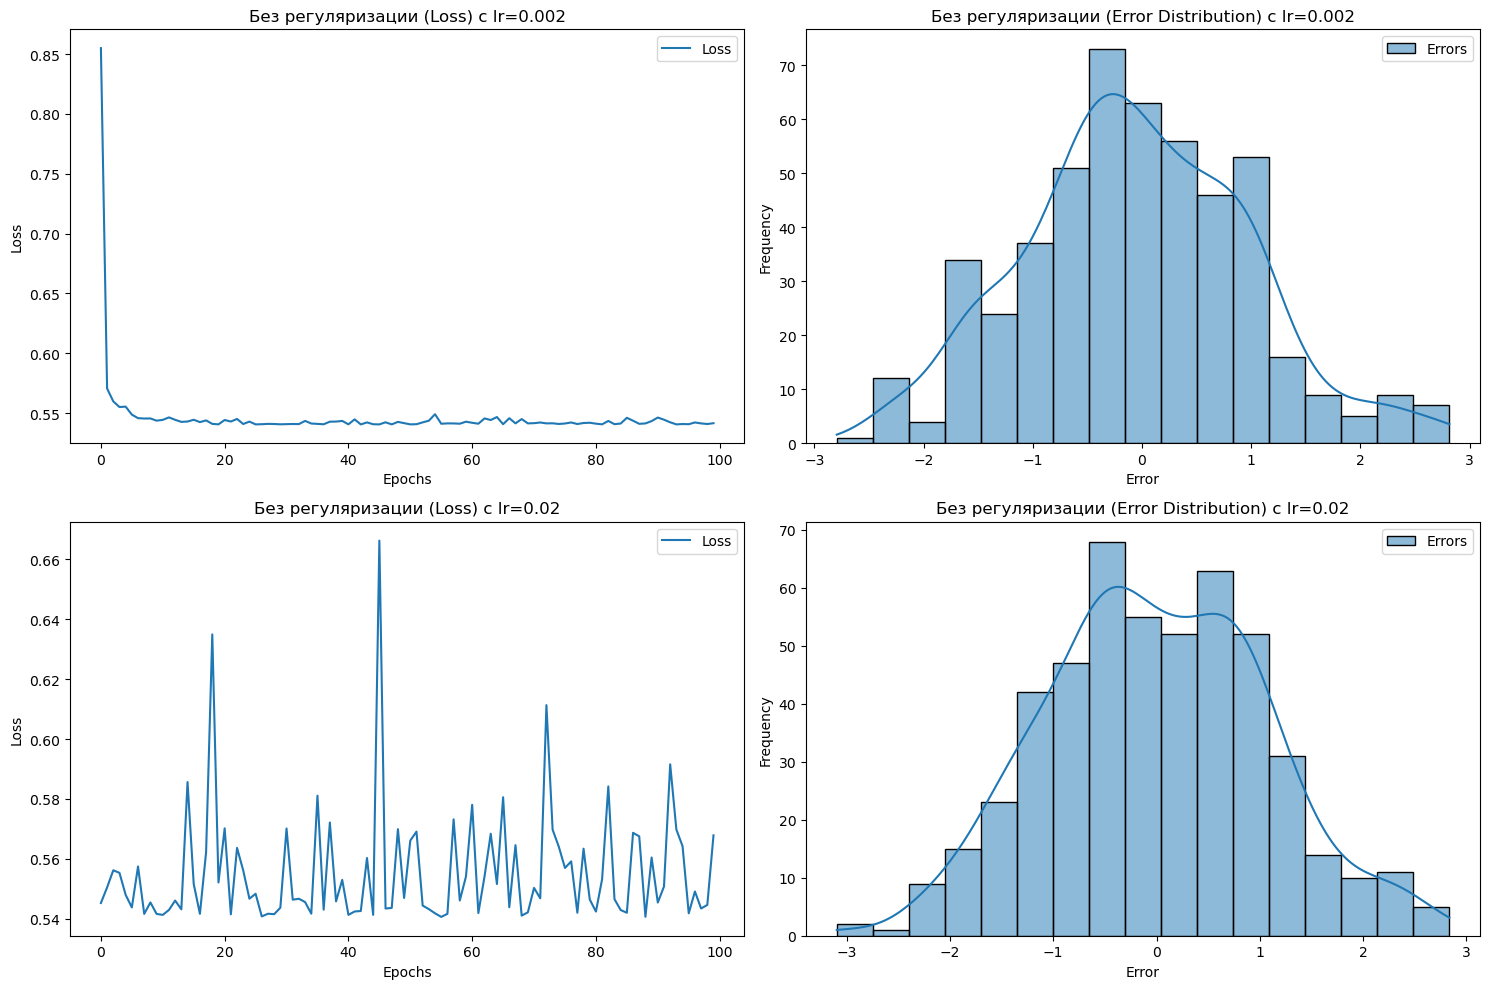

In [7]:
np.random.seed(1408)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_no_reg = LinearRegressionSGD(lr=0.002, epochs=100, reg_type=None)
model_no_reg.fit(X_b, y)
model_no_reg.plot_loss(ax=axes[0][0])
model_no_reg.plot_error_distribution(80, ax=axes[0][1])
axes[0][0].set_title("Без регуляризации (Loss) с lr=0.002")
axes[0][1].set_title("Без регуляризации (Error Distribution) с lr=0.002")

model_no_reg = LinearRegressionSGD(
    lr=0.02, epochs=100, reg_type=None
)  # судя по вторым графикам, не надо делать lr слишком большим
# оптимальное значение lr = 0.002
model_no_reg.fit(X_b, y)
model_no_reg.plot_loss(ax=axes[1][0])
model_no_reg.plot_error_distribution(80, ax=axes[1][1])
axes[1][0].set_title("Без регуляризации (Loss) с lr=0.02")
axes[1][1].set_title("Без регуляризации (Error Distribution) с lr=0.02")

plt.tight_layout()
plt.show()

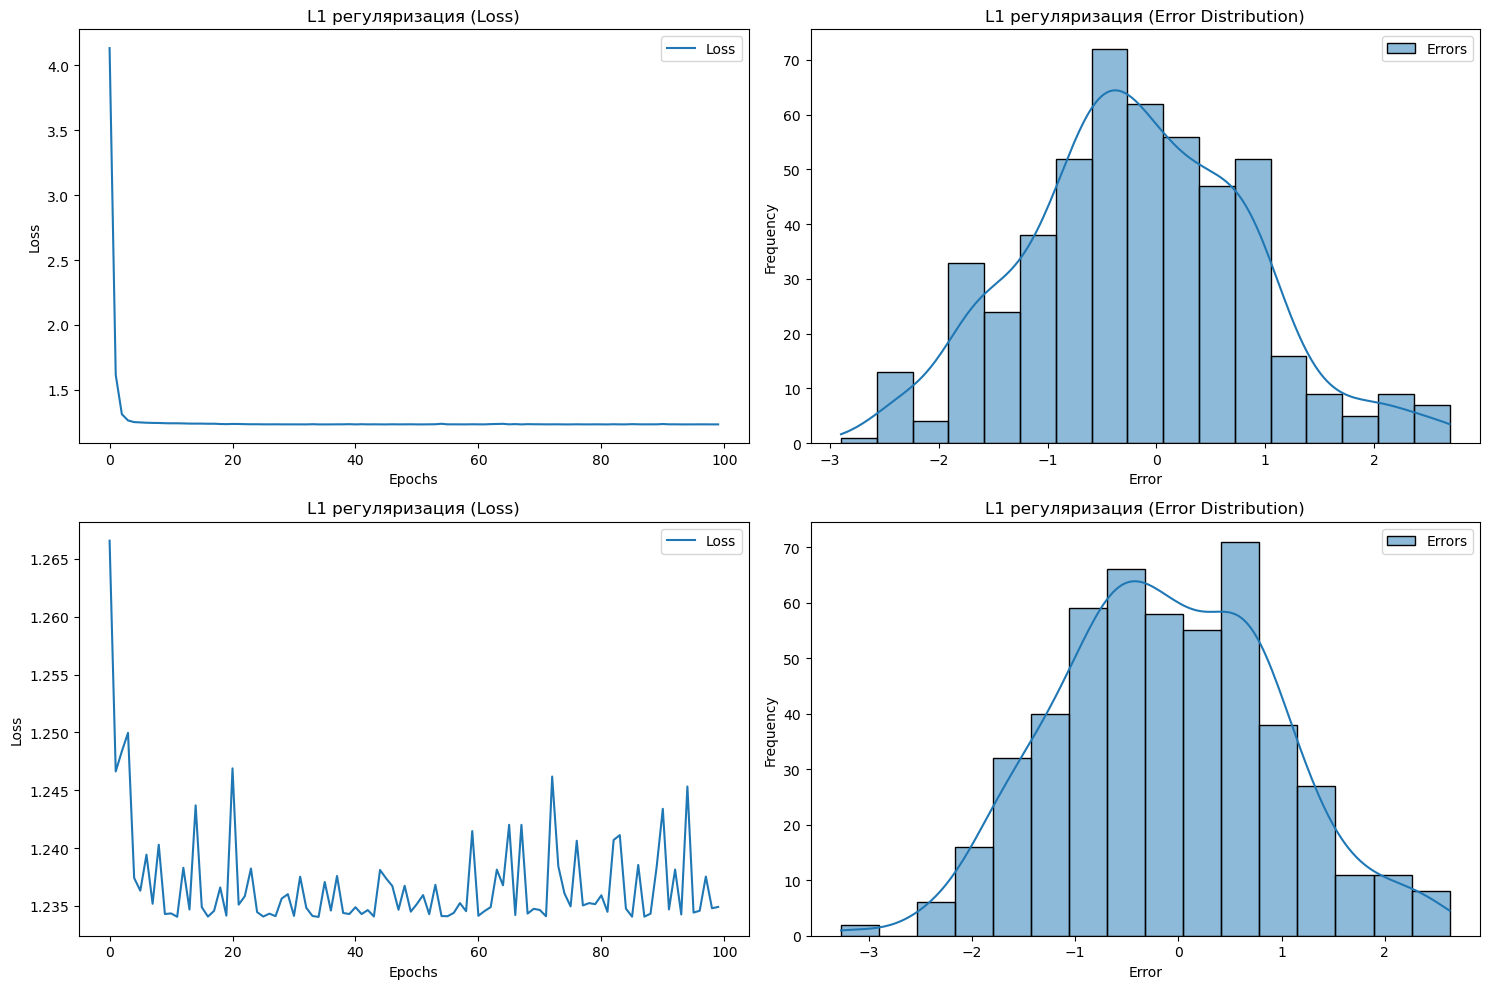

In [8]:
np.random.seed(1408)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_l1 = LinearRegressionSGD(lr=0.001, epochs=100, reg_type="l1", reg_lambda=0.1)
model_l1.fit(X_b, y)
model_l1.plot_loss(ax=axes[0][0])
model_l1.plot_error_distribution(80, ax=axes[0][1])
axes[0][0].set_title("L1 регуляризация (Loss)")
axes[0][1].set_title("L1 регуляризация (Error Distribution)")

model_l1 = LinearRegressionSGD(lr=0.004, epochs=100, reg_type="l1", reg_lambda=0.1)
model_l1.fit(X_b, y)
model_l1.plot_loss(ax=axes[1][0])
model_l1.plot_error_distribution(80, ax=axes[1][1])
axes[1][0].set_title("L1 регуляризация (Loss)")
axes[1][1].set_title("L1 регуляризация (Error Distribution)")

plt.tight_layout()
plt.show()

Как будто самый оптимальный вариант это L1 и lr=0.002. При lr > 0.002 пики начинают скакать, что как будто не есть гуд, а при 0.001 - все ровное, как доска...

## Часть 3. (15 баллов)

**Разбейте ваши данные** на две части в процентном соотношении 80/20, используя функцию `train_test_split` из `scikit-learn`. Первую часть используйте как **тренировочную выборку**, а а вторую - как **тестовую**.

Посмотрите, **как меняются значения лоссов** на тренировочной и тестовой выборке в процессе обучения. Какие модели больше переобучаются, а какие меньше?

*Если вы не понимаете как разбить вашу выборку, посмотрите другой файл домашки `hw3_data_analysis.ipynb`*

In [16]:
sample_size = 500
np.random.seed(1408)
X = 2 * np.random.rand(sample_size, 1)
y = 4 + 3 * X.squeeze() + np.random.randn(sample_size)

X_b = np.c_[np.ones((sample_size, 1)), X]

X_train, X_test, y_train, y_test = train_test_split(
    X_b, y, test_size=0.2, random_state=42
)

Train MAE: 0.8378391521658959
Test MAE: 0.8632836488610081
Train Loss: 1.225829935345985
Test Loss: 1.2723464645467368


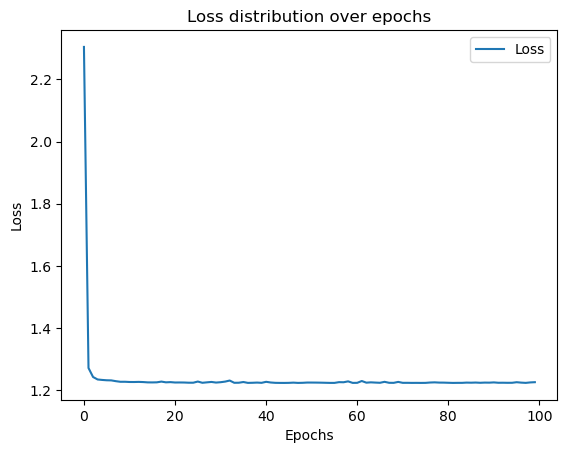

In [10]:
np.random.seed(1408)
model = LinearRegressionSGD(lr=0.002, epochs=100, reg_type="l1", reg_lambda=0.1)
model.fit(X_train, y_train)
model.plot_loss()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")

test_loss = model._compute_loss(X_test, y_test)
train_loss = model._compute_loss(X_train, y_train)

print(f"Train Loss: {train_loss}")
print(
    f"Test Loss: {test_loss}"
)  # серьезный разрыв между тестовым и тренировочным ошибкой (лоссом) говорит о переобучение модели

Вариант L1 и lr = 0.002, показывает маленькие различия между MAE между train и test, аналогично для Loss. Так что это модель действительно хорошо предсказывает

Train MAE: 0.8367827399454519
Test MAE: 0.8464220533500071
Train Loss: 0.5362528189498902
Test Loss: 0.5638287253703538


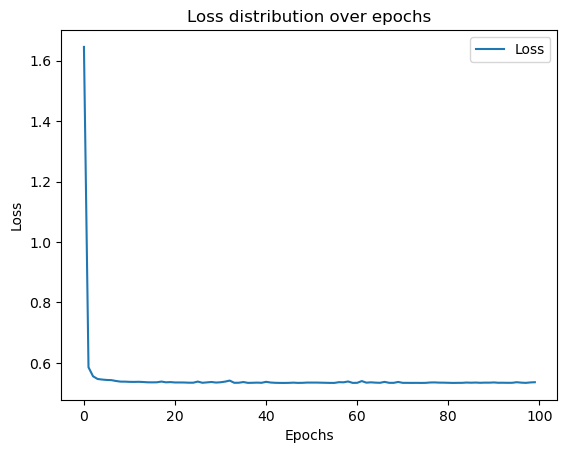

In [11]:
np.random.seed(1408)
model = LinearRegressionSGD(lr=0.002, epochs=100)
model.fit(X_train, y_train)
model.plot_loss()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")

test_loss = model._compute_loss(X_test, y_test)
train_loss = model._compute_loss(X_train, y_train)

print(f"Train Loss: {train_loss}")
print(
    f"Test Loss: {test_loss}"
)  # серьезный разрыв между тестовым и тренировочным ошибкой (лоссом) говорит о переобучение модели

Train MAE: 0.8700976829502732
Test MAE: 0.9221445387462507
Train Loss: 1.6866184832058988
Test Loss: 1.7826622574276991


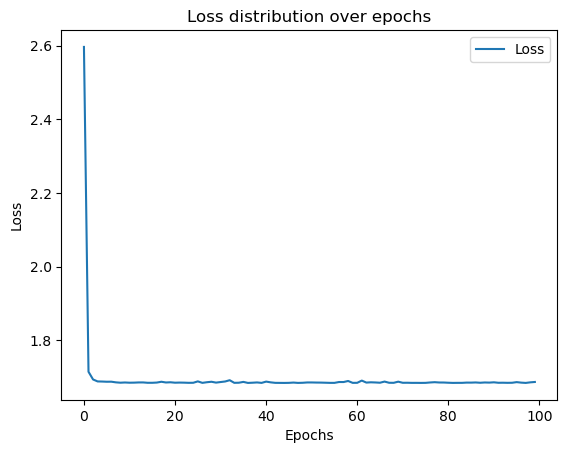

In [12]:
np.random.seed(1408)
model = LinearRegressionSGD(lr=0.002, epochs=100, reg_type="l2", reg_lambda=0.1)
model.fit(X_train, y_train)
model.plot_loss()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")

test_loss = model._compute_loss(X_test, y_test)
train_loss = model._compute_loss(X_train, y_train)

print(f"Train Loss: {train_loss}")
print(
    f"Test Loss: {test_loss}"
)  # серьезный разрыв между тестовым и тренировочным ошибкой (лоссом) говорит о переобучение модели

Train MAE: 0.8494090494707084
Test MAE: 0.8911783944111851
Train Loss: 1.4638832681621343
Test Loss: 1.5373190656696867


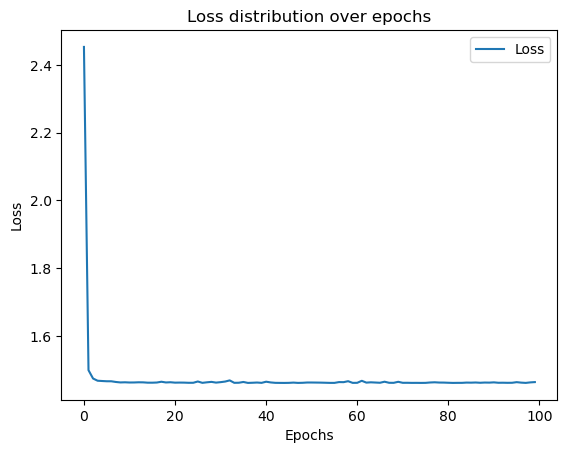

In [13]:
np.random.seed(1408)
model = LinearRegressionSGD(
    lr=0.002, epochs=100, reg_type="elastic_net", reg_lambda=0.1, alpha=0.5
)
model.fit(X_train, y_train)
model.plot_loss()

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")

test_loss = model._compute_loss(X_test, y_test)
train_loss = model._compute_loss(X_train, y_train)

print(f"Train Loss: {train_loss}")
print(
    f"Test Loss: {test_loss}"
)  # серьезный разрыв между тестовым и тренировочным ошибкой (лоссом) говорит о переобучение модели

Ну если запустить на всех моделях, то модель без регулязации снова показывает себя топово (минимальная разница между тестовой выборкой и обучающей по параметрам MAE и Loss), хотя L1 остается лучше L2 и elastic_net. Я остановлю свой выбор L1, потому что это сгенерированная случайная выборка. Если это выборка случайна, становится понятно, что L2 покажет себя плохо, потому что кореллированных значений нет, значит и elastic_net мимо. А различия без регулязации/L1 можно считать случайностью (как мне кажется)

**Отлично! Вы дошли до конца этой сложной части третьей домашки!**

Вы уже поняли, что мы ждём ваши впечатления. Особенно важно то, сколько времени у вас заняла эта часть. Нравятся ли вам задания с собственной реализацией методов и классов?

Делала два дня. Наверное в сумме часов 8-10. Очень долго тупила на первом задании, потом очень долго оформляла вторую и третью задачки. Реализация собственных методов и классов зашла хорошо, а вот математика в них не заходит 🙏

## Давайте следующий вопрос

Вставьте картинку, которая ассоциируется с вашим **любимым путешествием**. Пусть это будут горы или озёра, или любимая кафешка за пределами города, или фотка дома с котом, где вы провели какое-нибудь лето. Что угодно, где вам было комфортно и от чего у вас возникают тёплые воспоминания.

In [ ]:
# We travel for romance, we travel for architecture, and we travel to be lost.
# Ray Bradbury

Кошку зовут Муся и фотка с лета 2024. Я ловлю жуткий плюс вайб с этого фото.
Тайланд, прошлый НГ. Там было очень хорошо, хочется обратно...

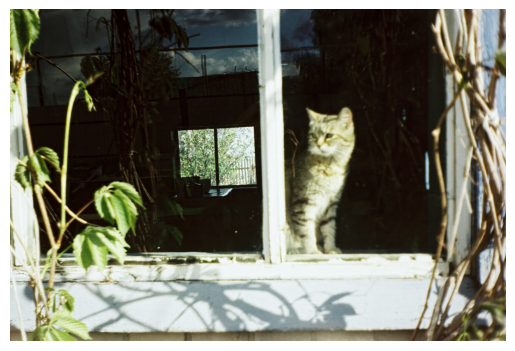

In [14]:
img = mpimg.imread("../data/кошкадеревня.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

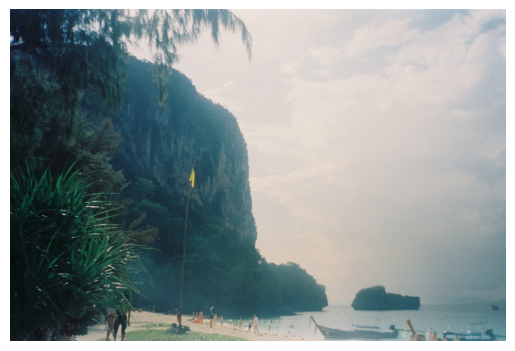

In [15]:
img = mpimg.imread("../data/тай.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()